# 📊 Análise de Ortogonalização de Sensores Sísmicos

Este notebook processa dados sísmicos e calcula a magnitude ortogonal (vetor resultante) dos 3 eixos de medida de cada sensor. O objetivo é encontrar para cada evento sísmico qual sensor/plano teve a maior magnitude ortogonal.

## 🎯 Objetivos:
- **Processar dados sísmicos** de múltiplos sensores e planos
- **Calcular magnitude ortogonal** usando a fórmula: √(x² + y² + z²)
- **Identificar sensores dominantes** por evento e por plano
- **Gerar relatórios** organizados por Plano H e Plano G

## 📋 Estrutura dos Dados:
- **Plano H**: Sensores HH (HHE, HHN, HHZ) e HN (HNE, HNN, HNZ)
- **Plano G**: Sensores GP (GP1, GP2, GPZ)
- **Plano E**: Sensores EL (ELE, ELN, ELZ) - se disponível

In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas:")
print("   • pandas: Manipulação de dados")
print("   • numpy: Cálculos matemáticos")
print("   • matplotlib: Visualizações")
print("   • re: Expressões regulares") 
print("   • collections.defaultdict: Estruturas de dados")

print("\n🔧 Funções a serem definidas:")
print("   • extract_sensor_info_updated(): Extrai informações dos sensores (incluindo MAC)")
print("   • calculate_orthogonal_magnitude(): Calcula magnitude 3D")
print("   • process_seismic_data_updated(): Processamento completo atualizado")
print("   • create_summary_results(): Cria resumo por plano")

✅ Bibliotecas importadas:
   • pandas: Manipulação de dados
   • numpy: Cálculos matemáticos
   • matplotlib: Visualizações
   • re: Expressões regulares
   • collections.defaultdict: Estruturas de dados

🔧 Funções a serem definidas:
   • extract_sensor_info_updated(): Extrai informações dos sensores (incluindo MAC)
   • calculate_orthogonal_magnitude(): Calcula magnitude 3D
   • process_seismic_data_updated(): Processamento completo atualizado
   • create_summary_results(): Cria resumo por plano


/home/pedrobook/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# 🔧 Helper Functions

def calculate_orthogonal_magnitude(x, y, z):
    """
    Calcula a magnitude ortogonal dos 3 eixos usando a fórmula: √(x² + y² + z²)
    
    Args:
        x, y, z (float): Valores de amplitude dos eixos
    
    Returns:
        float: Magnitude ortogonal calculada
    """
    return np.sqrt(x**2 + y**2 + z**2)

print("✅ Funções auxiliares definidas:")
print("   • calculate_orthogonal_magnitude(): Calcula magnitude 3D")

# Teste básico da função
exemplo_canal = "BR.ESM01.00.HHE"
print(f"\n🧪 Teste da função de magnitude:")
magnitude = calculate_orthogonal_magnitude(3, 4, 5)
print(f"   • Magnitude(3, 4, 5) = {magnitude:.2f}")
print(f"   • Esperado: 7.07")

✅ Funções auxiliares definidas:
   • calculate_orthogonal_magnitude(): Calcula magnitude 3D

🧪 Teste da função de magnitude:
   • Magnitude(3, 4, 5) = 7.07
   • Esperado: 7.07


In [3]:
# 🔄 Updated Helper Functions (Including MAC Sensors)

def extract_sensor_info_updated(channel_name):
    """
    Versão atualizada para extrair informações do sensor incluindo série MAC.
    
    Args:
        channel_name (str): Nome do canal
        Exemplos: 
        - 'BR.ESM05..HHE' (formato antigo)
        - 'SC.MAC11.00.ELE' (formato MAC)
        - 'SC.MAC13.01.HNE' (formato MAC)
    
    Returns:
        tuple: (sensor_name, plane, axis)
    """
    # Padrão para capturar diferentes formatos de sensores
    # Formato 1: BR.ESM05 ou SC.MAC11.00 ou SC.MAC13.01
    pattern = r'([A-Z]{2}\.[A-Z0-9]+(?:\.[0-9]+)?(?:\.[0-9]+)?)'
    match = re.search(pattern, channel_name)
    
    if not match:
        return None, None, None
    
    sensor_name = match.group(1)
    
    # Extrair plano e eixo baseado no formato do canal
    
    # Formato MAC: SC.MAC11.00.ELE, SC.MAC13.01.HNE, etc.
    if '.MAC' in channel_name:
        # Extrair o último componente (ELE, ELN, ELZ, HNE, HNN, HNZ)
        components = channel_name.split('.')
        if len(components) >= 4:
            axis = components[-1]  # ELE, ELN, ELZ, HNE, HNN, HNZ
            
            # Determinar plano baseado no eixo
            if axis in ['ELE', 'ELN', 'ELZ']:
                plane = 'E'  # Plano E para sensores EL
            elif axis in ['HNE', 'HNN', 'HNZ']:
                plane = 'H'  # Plano H para sensores HN
            else:
                plane = 'Unknown'
        else:
            return None, None, None
    
    # Formato tradicional BR: ..HH, ..HN, ..GP, ..EL
    elif '..HH' in channel_name:
        plane = 'H'
        axis = channel_name.split('..')[-1]  # HHE, HHN, HHZ
    elif '..HN' in channel_name:
        plane = 'H'
        axis = channel_name.split('..')[-1]  # HNE, HNN, HNZ
    elif '..GP' in channel_name:
        plane = 'G'
        axis = channel_name.split('..')[-1]  # GP1, GP2, GPZ
    elif '..EL' in channel_name:
        plane = 'E'  # Considerando EL como um plano especial
        axis = channel_name.split('..')[-1]  # ELE, ELN, ELZ
    else:
        # Casos especiais
        if '.HH' in channel_name:
            plane = 'H'
            axis = channel_name.split('.')[-1]  # HH1, HH2, HHZ
        else:
            plane = 'Unknown'
            axis = channel_name.split('..')[-1] if '..' in channel_name else channel_name.split('.')[-1]
    
    return sensor_name, plane, axis

# Função de processamento atualizada
def process_seismic_data_updated(csv_file):
    """
    Versão atualizada da função de processamento incluindo sensores MAC.
    """
    # Carregar dados
    df = pd.read_csv(csv_file)
    
    # Dicionário para armazenar dados organizados por event_id e sensor
    data_by_event = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    # Organizar dados por event_id, sensor, plano e eixo
    for _, row in df.iterrows():
        event_id = row['event_id']
        channel_name = row['channel_name']
        max_amplitude = abs(row['max_amplitude'])  # Usar valor absoluto
        
        sensor_name, plane, axis = extract_sensor_info_updated(channel_name)
        
        if sensor_name and plane and axis:
            data_by_event[event_id][sensor_name][plane][axis] = max_amplitude
    
    # Lista para armazenar os resultados
    results = []
    
    # Processar cada evento
    for event_id, sensors_data in data_by_event.items():
        max_magnitude = 0
        best_sensor = None
        best_plane = None
        event_results = {}
        
        for sensor_name, planes_data in sensors_data.items():
            for plane, axes_data in planes_data.items():
                # Definir mapeamento de eixos para cada plano (ATUALIZADO)
                if plane == 'H':
                    # Plano H: HHE, HHN, HHZ ou HNE, HNN, HNZ ou HH1, HH2, HHZ
                    axis_map = {
                        'x': ['HHE', 'HNE', 'HH1'],
                        'y': ['HHN', 'HNN', 'HH2'], 
                        'z': ['HHZ', 'HHZ', 'HHZ']
                    }
                elif plane == 'G':
                    # Plano G: GP1, GP2, GPZ
                    axis_map = {
                        'x': ['GP1'],
                        'y': ['GP2'],
                        'z': ['GPZ']
                    }
                elif plane == 'E':
                    # Plano E: ELE, ELN, ELZ (incluindo sensores MAC)
                    axis_map = {
                        'x': ['ELE'],
                        'y': ['ELN'],
                        'z': ['ELZ']
                    }
                else:
                    continue
                
                # Extrair valores para x, y, z
                x_val = None
                y_val = None
                z_val = None
                
                for axis, amplitude in axes_data.items():
                    if axis in axis_map['x']:
                        x_val = amplitude
                    elif axis in axis_map['y']:
                        y_val = amplitude
                    elif axis in axis_map['z']:
                        z_val = amplitude
                
                # Calcular magnitude ortogonal se tivermos os 3 eixos
                if x_val is not None and y_val is not None and z_val is not None:
                    magnitude = calculate_orthogonal_magnitude(x_val, y_val, z_val)
                    
                    # Armazenar resultado
                    key = f"{sensor_name}_{plane}"
                    event_results[key] = {
                        'event_id': event_id,
                        'sensor': sensor_name,
                        'plane': plane,
                        'x_amplitude': x_val,
                        'y_amplitude': y_val,
                        'z_amplitude': z_val,
                        'orthogonal_magnitude': magnitude
                    }
                    
                    # Verificar se é o maior
                    if magnitude > max_magnitude:
                        max_magnitude = magnitude
                        best_sensor = sensor_name
                        best_plane = plane
        
        # Adicionar todos os resultados do evento
        for key, result in event_results.items():
            result['is_max'] = (result['sensor'] == best_sensor and result['plane'] == best_plane)
            results.append(result)
    
    return pd.DataFrame(results)

# Teste das funções atualizadas
print("✅ Funções atualizadas definidas (incluindo sensores MAC):")
print("   • extract_sensor_info_updated(): Inclui formato MAC")
print("   • process_seismic_data_updated(): Processamento completo atualizado")

# Exemplos de teste com os novos formatos
print(f"\n🔍 Exemplos de sensores MAC:")
exemplos_mac = [
    "SC.MAC11.00.ELE",
    "SC.MAC11.00.ELN", 
    "SC.MAC11.00.ELZ",
    "SC.MAC11.01.HNE",
    "SC.MAC13.01.HNN",
    "SC.MAC13.01.HNZ"
]

for exemplo in exemplos_mac:
    sensor, plane, axis = extract_sensor_info_updated(exemplo)
    print(f"   • {exemplo:20s} → Sensor: {sensor:15s} | Plano: {plane} | Eixo: {axis}")

print(f"\n🔍 Exemplos de sensores BR (compatibilidade):")
exemplos_br = ["BR.ESM05..HHE", "BR.ESM06..GP1", "BR.ESM07..ELE"]
for exemplo in exemplos_br:
    sensor, plane, axis = extract_sensor_info_updated(exemplo)
    print(f"   • {exemplo:20s} → Sensor: {sensor:15s} | Plano: {plane} | Eixo: {axis}")

print(f"\n📋 Planos suportados:")
print(f"   • Plano H: Sensores HH, HN (BR) + HN (MAC)")
print(f"   • Plano G: Sensores GP (BR)")
print(f"   • Plano E: Sensores EL (BR) + EL (MAC)")
print(f"\n💡 Para usar as funções atualizadas, substitua:")
print(f"   process_seismic_data() → process_seismic_data_updated()")

✅ Funções atualizadas definidas (incluindo sensores MAC):
   • extract_sensor_info_updated(): Inclui formato MAC
   • process_seismic_data_updated(): Processamento completo atualizado

🔍 Exemplos de sensores MAC:
   • SC.MAC11.00.ELE      → Sensor: SC.MAC11.00     | Plano: E | Eixo: ELE
   • SC.MAC11.00.ELN      → Sensor: SC.MAC11.00     | Plano: E | Eixo: ELN
   • SC.MAC11.00.ELZ      → Sensor: SC.MAC11.00     | Plano: E | Eixo: ELZ
   • SC.MAC11.01.HNE      → Sensor: SC.MAC11.01     | Plano: H | Eixo: HNE
   • SC.MAC13.01.HNN      → Sensor: SC.MAC13.01     | Plano: H | Eixo: HNN
   • SC.MAC13.01.HNZ      → Sensor: SC.MAC13.01     | Plano: H | Eixo: HNZ

🔍 Exemplos de sensores BR (compatibilidade):
   • BR.ESM05..HHE        → Sensor: BR.ESM05        | Plano: H | Eixo: HHE
   • BR.ESM06..GP1        → Sensor: BR.ESM06        | Plano: G | Eixo: GP1
   • BR.ESM07..ELE        → Sensor: BR.ESM07        | Plano: E | Eixo: ELE

📋 Planos suportados:
   • Plano H: Sensores HH, HN (BR) + HN (MAC

In [4]:
# ⚙️ Define Data Processing Functions

def create_summary_results(df):
    """
    Cria um resumo com a maior magnitude de cada plano (H e G) por evento.
    
    Args:
        df (pd.DataFrame): DataFrame com todos os resultados
    
    Returns:
        pd.DataFrame: DataFrame com resumo organizado por plano
    """
    # Lista para armazenar os resultados finais
    final_results = []
    
    # Agrupar por event_id
    for event_id in df['event_id'].unique():
        event_data = df[df['event_id'] == event_id]
        
        # Separar dados por plano
        h_data = event_data[event_data['plane'] == 'H']
        g_data = event_data[event_data['plane'] == 'G']
        e_data = event_data[event_data['plane'] == 'E']  # Incluir plano E se existir
        
        # Encontrar maior magnitude do Plano H
        if len(h_data) > 0:
            max_h = h_data.loc[h_data['orthogonal_magnitude'].idxmax()]
            final_results.append({
                'event_id': event_id,
                'plane': 'Plano_H',
                'max_magnitude': max_h['orthogonal_magnitude'],
                'sensor': max_h['sensor'],
                'x_amplitude': max_h['x_amplitude'],
                'y_amplitude': max_h['y_amplitude'],
                'z_amplitude': max_h['z_amplitude']
            })
        
        # Encontrar maior magnitude do Plano G
        if len(g_data) > 0:
            max_g = g_data.loc[g_data['orthogonal_magnitude'].idxmax()]
            final_results.append({
                'event_id': event_id,
                'plane': 'Plano_G',
                'max_magnitude': max_g['orthogonal_magnitude'],
                'sensor': max_g['sensor'],
                'x_amplitude': max_g['x_amplitude'],
                'y_amplitude': max_g['y_amplitude'],
                'z_amplitude': max_g['z_amplitude']
            })
        
        # Encontrar maior magnitude do Plano E (se existir)
        if len(e_data) > 0:
            max_e = e_data.loc[e_data['orthogonal_magnitude'].idxmax()]
            final_results.append({
                'event_id': event_id,
                'plane': 'Plano_E',
                'max_magnitude': max_e['orthogonal_magnitude'],
                'sensor': max_e['sensor'],
                'x_amplitude': max_e['x_amplitude'],
                'y_amplitude': max_e['y_amplitude'],
                'z_amplitude': max_e['z_amplitude']
            })
    
    # Converter para DataFrame e ordenar
    summary_df = pd.DataFrame(final_results)
    summary_df = summary_df.sort_values(['event_id', 'plane'])
    
    return summary_df

print("✅ Funções de processamento definidas:")
print("   • create_summary_results(): Cria resumo por plano")
print("   • process_seismic_data_updated(): Função principal (definida posteriormente)")

✅ Funções de processamento definidas:
   • create_summary_results(): Cria resumo por plano
   • process_seismic_data_updated(): Função principal (definida posteriormente)


In [6]:
# 📂 Load and Process ALL Seismic Data Files (Updated for MAC Sensors)

import os
import glob
from pathlib import Path

# Definir pasta com os arquivos CSV
data_folder = '/home/pedrobook/braskem/data_analysis/Braskem_dados/Eventos/'
# data_folder = '/content/'  # Para Google Colab

print("🔄 Iniciando processamento de TODOS os arquivos CSV sísmicos...")
print(f"📁 Pasta de dados: {data_folder}")

# Buscar todos os arquivos CSV na pasta
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))
csv_files = [f for f in csv_files if not f.endswith('_coords.csv')]  # Excluir arquivos de coordenadas

print(f"📊 Arquivos CSV encontrados: {len(csv_files)}")
for i, file in enumerate(csv_files, 1):
    filename = os.path.basename(file)
    print(f"   {i:2d}. {filename}")

# Dicionário para armazenar resultados de cada arquivo
all_results = {}
all_summaries = {}

print(f"\n🔄 Processando cada arquivo...")

try:
    for i, csv_file in enumerate(csv_files, 1):
        filename = os.path.basename(csv_file)
        print(f"\n{'='*60}")
        print(f"📂 PROCESSANDO ARQUIVO {i}/{len(csv_files)}: {filename}")
        print(f"{'='*60}")
        
        try:
            # Processar dados sísmicos usando a função ATUALIZADA
            file_results = process_seismic_data_updated(csv_file)
            
            print(f"✅ Arquivo processado com sucesso!")
            print(f"📊 Resultados: {len(file_results):,} registros")
            print(f"🎯 Eventos únicos: {file_results['event_id'].nunique():,}")
            print(f"🔧 Sensores únicos: {file_results['sensor'].nunique()}")
            print(f"🌐 Planos encontrados: {sorted(file_results['plane'].unique())}")
            
            # Verificar sensores MAC
            mac_sensors = file_results[file_results['sensor'].str.contains('MAC', na=False)]
            if len(mac_sensors) > 0:
                print(f"🔍 Sensores MAC: {mac_sensors['sensor'].nunique()} únicos")
            
            # Adicionar coluna com nome do arquivo para identificação
            file_results['source_file'] = filename
            
            # Armazenar resultados
            all_results[filename] = file_results
            
            # Criar resumo para este arquivo
            file_summary = create_summary_results(file_results)
            file_summary['source_file'] = filename
            all_summaries[filename] = file_summary
            
            print(f"📋 Resumo: {len(file_summary):,} registros")
            
        except Exception as e:
            print(f"❌ Erro ao processar {filename}: {e}")
            continue
    
    # Combinar todos os resultados
    if all_results:
        results_df = pd.concat(all_results.values(), ignore_index=True)
        summary_df = pd.concat(all_summaries.values(), ignore_index=True)
        
        print(f"\n{'='*60}")
        print(f"🎉 PROCESSAMENTO GLOBAL CONCLUÍDO")
        print(f"{'='*60}")
        print(f"✅ Arquivos processados com sucesso: {len(all_results)}")
        print(f"📊 Total de resultados: {len(results_df):,} registros")
        print(f"🎯 Total de eventos únicos: {results_df['event_id'].nunique():,}")
        print(f"🔧 Total de sensores únicos: {results_df['sensor'].nunique()}")
        print(f"🌐 Planos encontrados: {sorted(results_df['plane'].unique())}")
        print(f"📋 Total no resumo: {len(summary_df):,} registros")
        
        # Estatísticas por arquivo
        print(f"\n📂 Estatísticas por arquivo:")
        file_stats = results_df.groupby('source_file').agg({
            'event_id': 'nunique',
            'sensor': 'nunique', 
            'orthogonal_magnitude': 'count'
        }).round(2)
        file_stats.columns = ['Eventos', 'Sensores', 'Registros']
        print(file_stats.to_string())
        
    else:
        print(f"❌ Nenhum arquivo foi processado com sucesso!")
        
except Exception as e:
    print(f"❌ Erro geral durante o processamento: {e}")
    print(f"   • Colunas: {list(results_df.columns)}")
    print(f"   • Tipos de dados:")
    for col in results_df.columns:
        print(f"     - {col}: {results_df[col].dtype}")
        
    # Estatísticas por plano (incluindo E se presente)
    if len(results_df) > 0:
        plane_counts = results_df['plane'].value_counts()
        print(f"\n📈 Distribuição por plano nos dados completos:")
        for plane, count in plane_counts.items():
            percentage = (count / len(results_df)) * 100
            print(f"   • Plano {plane}: {count:,} registros ({percentage:.1f}%)")
        
except FileNotFoundError:
    print("❌ Erro: Arquivo não encontrado!")
    print("📝 Para usar no Google Colab:")
    print("   1. Faça upload do arquivo eventsA001_cut25seg.csv")
    print("   2. Ou conecte ao Google Drive e ajuste o caminho")
    print("   3. Ou use: csv_file = '/content/nome_do_arquivo.csv'")
except Exception as e:
    print(f"❌ Erro durante o processamento: {e}")
    
print(f"\n🆕 NOVOS SENSORES SUPORTADOS:")
print(f"   • SC.MAC11.00.ELE/ELN/ELZ (Plano E)")
print(f"   • SC.MAC11.01.HNE/HNN/HNZ (Plano H)")
print(f"   • SC.MAC13.00.ELE/ELN/ELZ (Plano E)")
print(f"   • SC.MAC13.01.HNE/HNN/HNZ (Plano H)")

🔄 Iniciando processamento de TODOS os arquivos CSV sísmicos...
📁 Pasta de dados: /home/pedrobook/braskem/data_analysis/Braskem_dados/Eventos/
📊 Arquivos CSV encontrados: 10
    1. eventsNDA1_cut25seg.csv
    2. eventsNDA0_cut25seg.csv
    3. eventsA002_cut25seg.csv
    4. eventsD001_cut25seg.csv
    5. feature_correlations.csv
    6. eventsA001_cut25seg.csv
    7. eventsF001_cut25seg.csv
    8. eventsNDA_cut25seg.csv
    9. eventsA003_cut25seg.csv
   10. eventsE001_cut25seg.csv

🔄 Processando cada arquivo...

📂 PROCESSANDO ARQUIVO 1/10: eventsNDA1_cut25seg.csv
✅ Arquivo processado com sucesso!
📊 Resultados: 4,884 registros
🎯 Eventos únicos: 1,218
🔧 Sensores únicos: 16
🌐 Planos encontrados: ['E', 'G', 'H']
🔍 Sensores MAC: 6 únicos
✅ Arquivo processado com sucesso!
📊 Resultados: 4,884 registros
🎯 Eventos únicos: 1,218
🔧 Sensores únicos: 16
🌐 Planos encontrados: ['E', 'G', 'H']
🔍 Sensores MAC: 6 únicos
📋 Resumo: 2,784 registros

📂 PROCESSANDO ARQUIVO 2/10: eventsNDA0_cut25seg.csv
📋 Resumo

In [7]:
# 📋 Create Summary Results

print("🔄 Criando resumo organizado por planos...")

try:
    # Criar resumo dos resultados
    summary_df = create_summary_results(results_df)
    
    print("✅ Resumo criado com sucesso!")
    print(f"📊 Total de linhas no resumo: {len(summary_df):,}")
    print(f"🎯 Eventos únicos no resumo: {summary_df['event_id'].nunique():,}")
    
    # Verificar distribuição por plano
    plane_distribution = summary_df['plane'].value_counts()
    print(f"\n📈 Distribuição por plano:")
    for plane, count in plane_distribution.items():
        percentage = (count / len(summary_df)) * 100
        print(f"   • {plane}: {count:,} registros ({percentage:.1f}%)")
    
    # Verificar se temos 2 linhas por evento (idealmente)
    events_per_line = summary_df.groupby('event_id').size()
    print(f"\n🔍 Análise de completude:")
    print(f"   • Eventos com 2 planos: {(events_per_line == 2).sum():,}")
    print(f"   • Eventos com 1 plano: {(events_per_line == 1).sum():,}")
    print(f"   • Outros casos: {(events_per_line > 2).sum():,}")
    
    print(f"\n📋 Colunas do resumo: {list(summary_df.columns)}")
    
except NameError:
    print("❌ Erro: Execute primeiro a célula de processamento dos dados!")
except Exception as e:
    print(f"❌ Erro ao criar resumo: {e}")

🔄 Criando resumo organizado por planos...
✅ Resumo criado com sucesso!
📊 Total de linhas no resumo: 33,356
🎯 Eventos únicos no resumo: 14,713

📈 Distribuição por plano:
   • Plano_H: 14,203 registros (42.6%)
   • Plano_G: 11,170 registros (33.5%)
   • Plano_E: 7,983 registros (23.9%)

🔍 Análise de completude:
   • Eventos com 2 planos: 8,255
   • Eventos com 1 plano: 1,264
   • Outros casos: 5,194

📋 Colunas do resumo: ['event_id', 'plane', 'max_magnitude', 'sensor', 'x_amplitude', 'y_amplitude', 'z_amplitude']
✅ Resumo criado com sucesso!
📊 Total de linhas no resumo: 33,356
🎯 Eventos únicos no resumo: 14,713

📈 Distribuição por plano:
   • Plano_H: 14,203 registros (42.6%)
   • Plano_G: 11,170 registros (33.5%)
   • Plano_E: 7,983 registros (23.9%)

🔍 Análise de completude:
   • Eventos com 2 planos: 8,255
   • Eventos com 1 plano: 1,264
   • Outros casos: 5,194

📋 Colunas do resumo: ['event_id', 'plane', 'max_magnitude', 'sensor', 'x_amplitude', 'y_amplitude', 'z_amplitude']


In [8]:
# 💾 Verify Results Ready for CSV Creation

print("💾 Verificando se os resultados estão prontos para criação de CSV...")

try:
    if 'all_results' not in locals() or not all_results:
        print("❌ Erro: Execute primeiro o processamento dos dados!")
        print("💡 Execute a célula '📂 Load and Process ALL Seismic Data Files' primeiro")
    else:
        print("✅ Resultados estão prontos!")
        print(f"📊 Arquivos processados: {len(all_results)}")
        print(f"📋 Total de eventos únicos: {sum(df['event_id'].nunique() for df in all_results.values()):,}")
        
        print(f"\n📝 Para criar os arquivos CSV individuais:")
        print(f"   👉 Execute a próxima célula: '📄 Create Individual CSV Files'")
        
        print(f"\n📊 Resumo dos dados disponíveis:")
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename] 
            print(f"   📁 {filename}")
            print(f"      • Eventos: {file_results['event_id'].nunique():,}")
            print(f"      • Registros resumo: {len(file_summary):,}")
            print(f"      • Planos: {sorted(file_results['plane'].unique())}")
        
        print(f"\n🎯 PASTA DE DESTINO: resultados_csv/ (formato simplificado)")
        
except Exception as e:
    print(f"❌ Erro ao verificar resultados: {e}")
    import traceback
    traceback.print_exc()

💾 Verificando se os resultados estão prontos para criação de CSV...
✅ Resultados estão prontos!
📊 Arquivos processados: 9
📋 Total de eventos únicos: 21,928

📝 Para criar os arquivos CSV individuais:
   👉 Execute a próxima célula: '📄 Create Individual CSV Files'

📊 Resumo dos dados disponíveis:
   📁 eventsNDA1_cut25seg.csv
      • Eventos: 1,218
      • Registros resumo: 2,784
      • Planos: ['E', 'G', 'H']
   📁 eventsNDA0_cut25seg.csv
      • Eventos: 5,989
      • Registros resumo: 13,273
      • Planos: ['E', 'G', 'H']
   📁 eventsA002_cut25seg.csv
      • Eventos: 1,352
      • Registros resumo: 3,033
      • Planos: ['E', 'G', 'H']
   📁 eventsD001_cut25seg.csv
      • Eventos: 1,806
      • Registros resumo: 3,902
      • Planos: ['E', 'G', 'H']
   📁 eventsA001_cut25seg.csv
      • Eventos: 2,070
      • Registros resumo: 5,353
      • Planos: ['E', 'G', 'H']
   📁 eventsF001_cut25seg.csv
      • Eventos: 1,094
      • Registros resumo: 2,785
      • Planos: ['E', 'G', 'H']
   📁 eve

In [9]:
# 📄 Create Individual CSV Files for Each Processed File

print("📄 Criando arquivos CSV individuais para cada arquivo processado...")

try:
    if 'all_results' not in locals() or not all_results:
        print("❌ Erro: Execute primeiro o processamento dos dados!")
    else:
        # Criar pasta de resultados
        # output_folder = '/content/resultados_csv/'  # Para Colab
        output_folder = '/home/pedrobook/braskem/data_analysis/resultados_csv/'  # Para local
        
        import os
        os.makedirs(output_folder, exist_ok=True)
        
        print(f"📁 Pasta de resultados: {output_folder}")
        
        # Contador de arquivos criados
        files_created = 0
        
        # Criar arquivo CSV para cada arquivo processado
        for filename, file_summary in all_summaries.items():
            # Nome base do arquivo (sem extensão)
            base_name = filename.replace('.csv', '')
            
            # Arquivo de saída para este arquivo específico
            output_file = os.path.join(output_folder, f'{base_name}_results.csv')
            
            # Salvar resumo (formato principal solicitado)
            file_summary.to_csv(output_file, index=False)
            
            files_created += 1
            
            print(f"   ✅ {base_name}_results.csv")
            print(f"      📊 Registros: {len(file_summary):,}")
            print(f"      🎯 Eventos únicos: {file_summary['event_id'].nunique():,}")
            print(f"      🌐 Planos: {sorted(file_summary['plane'].unique())}")
            
            # Mostrar estatísticas rápidas
            events_per_line = file_summary.groupby('event_id').size()
            complete_events = (events_per_line == 2).sum()
            print(f"      ✅ Eventos completos (H+G): {complete_events:,}")
            print()
        
        # Criar arquivo consolidado adicional (opcional)
        if len(all_summaries) > 1:
            consolidated_file = os.path.join(output_folder, 'CONSOLIDADO_todos_arquivos.csv')
            
            # Combinar todos os resumos
            all_summaries_list = []
            for filename, file_summary in all_summaries.items():
                # Adicionar coluna de origem se não existir
                if 'source_file' not in file_summary.columns:
                    file_summary = file_summary.copy()
                    file_summary['source_file'] = filename
                all_summaries_list.append(file_summary)
            
            consolidated_df = pd.concat(all_summaries_list, ignore_index=True)
            consolidated_df.to_csv(consolidated_file, index=False)
            
            files_created += 1
            print(f"   ✅ CONSOLIDADO_todos_arquivos.csv")
            print(f"      📊 Total de registros: {len(consolidated_df):,}")
            print(f"      📁 Arquivos incluídos: {len(all_summaries)}")
            print()
        
        # Criar arquivo de estatísticas gerais
        stats_file = os.path.join(output_folder, 'ESTATISTICAS_PROCESSAMENTO.csv')
        
        # Criar DataFrame com estatísticas por arquivo
        stats_data = []
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename]
            events_per_line = file_summary.groupby('event_id').size()
            
            stats_data.append({
                'arquivo_origem': filename,
                'total_registros_resumo': len(file_summary),
                'eventos_unicos': file_summary['event_id'].nunique(),
                'sensores_unicos': file_results['sensor'].nunique(),
                'planos_encontrados': ', '.join(sorted(file_results['plane'].unique())),
                'eventos_completos_H_G': (events_per_line == 2).sum(),
                'eventos_parciais': (events_per_line == 1).sum(),
                'taxa_completude_percent': round(((events_per_line == 2).sum() / file_results['event_id'].nunique()) * 100, 1) if file_results['event_id'].nunique() > 0 else 0,
                'magnitude_media': round(file_results['orthogonal_magnitude'].mean(), 6),
                'magnitude_maxima': round(file_results['orthogonal_magnitude'].max(), 6),
                'sensores_mac_detectados': len(file_results[file_results['sensor'].str.contains('MAC', na=False)])
            })
        
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(stats_file, index=False)
        
        files_created += 1
        print(f"   ✅ ESTATISTICAS_PROCESSAMENTO.csv")
        print(f"      📊 Estatísticas de {len(all_results)} arquivos")
        
        # Resumo final
        print(f"\n{'='*60}")
        print(f"🎉 CRIAÇÃO DE ARQUIVOS CSV CONCLUÍDA")
        print(f"{'='*60}")
        print(f"📁 Pasta de resultados: {output_folder}")
        print(f"📊 Total de arquivos criados: {files_created}")
        print(f"   • {len(all_summaries)} arquivos individuais de resultados")
        if len(all_summaries) > 1:
            print(f"   • 1 arquivo consolidado")
        print(f"   • 1 arquivo de estatísticas")
        
        print(f"\n📝 Estrutura dos arquivos:")
        print(f"   🔸 [nome_arquivo]_results.csv - Resultado principal para cada arquivo")
        print(f"   🔸 CONSOLIDADO_todos_arquivos.csv - Todos os resultados juntos (se múltiplos arquivos)")
        print(f"   🔸 ESTATISTICAS_PROCESSAMENTO.csv - Métricas de processamento")
        
        print(f"\n📋 Formato dos arquivos de resultado:")
        print(f"   • Colunas: event_id, plane, max_magnitude, sensor, x_amplitude, y_amplitude, z_amplitude")
        print(f"   • Duas linhas por evento: Plano_H e Plano_G (quando disponível)")
        print(f"   • Apenas a MAIOR magnitude de cada plano por evento")
        
        # Para Google Colab - instruções de download
        print(f"\n📥 Para download no Google Colab:")
        print(f"   import zipfile, os")
        print(f"   # Compactar todos os resultados")
        print(f"   with zipfile.ZipFile('/content/resultados_ortogonalizacao.zip', 'w') as zipf:")
        print(f"       for file in os.listdir('{output_folder}'):")
        print(f"           zipf.write(os.path.join('{output_folder}', file), file)")
        print(f"   # Download")
        print(f"   from google.colab import files")
        print(f"   files.download('/content/resultados_ortogonalizacao.zip')")
        
except Exception as e:
    print(f"❌ Erro ao criar arquivos CSV: {e}")
    import traceback
    traceback.print_exc()

📄 Criando arquivos CSV individuais para cada arquivo processado...
📁 Pasta de resultados: /home/pedrobook/braskem/data_analysis/resultados_csv/
   ✅ eventsNDA1_cut25seg_results.csv
      📊 Registros: 2,784
      🎯 Eventos únicos: 1,218
      🌐 Planos: ['Plano_E', 'Plano_G', 'Plano_H']
      ✅ Eventos completos (H+G): 544

   ✅ eventsNDA0_cut25seg_results.csv
      📊 Registros: 13,273
      🎯 Eventos únicos: 5,989
      🌐 Planos: ['Plano_E', 'Plano_G', 'Plano_H']
      ✅ Eventos completos (H+G): 2,954

   ✅ eventsA002_cut25seg_results.csv
      📊 Registros: 3,033
      🎯 Eventos únicos: 1,352
      🌐 Planos: ['Plano_E', 'Plano_G', 'Plano_H']
      ✅ Eventos completos (H+G): 1,023

   ✅ eventsD001_cut25seg_results.csv
      📊 Registros: 3,902
      🎯 Eventos únicos: 1,806
      🌐 Planos: ['Plano_E', 'Plano_G', 'Plano_H']
      ✅ Eventos completos (H+G): 1,514

   ✅ eventsD001_cut25seg_results.csv
      📊 Registros: 3,902
      🎯 Eventos únicos: 1,806
      🌐 Planos: ['Plano_E', 'Plano_G'

In [10]:
# 📄 Create Individual CSV Files for Each Processed File

print("📄 Criando arquivos CSV individuais para cada arquivo processado...")

try:
    if 'all_results' not in locals() or not all_results:
        print("❌ Erro: Execute primeiro o processamento dos dados!")
    else:
        # Criar pasta de resultados
        output_folder = '/content/resultados_csv/'  # Para Colab
        # output_folder = '/home/pedrobook/braskem/data_analysis/resultados_csv/'  # Para local
        
        import os
        os.makedirs(output_folder, exist_ok=True)
        
        print(f"📁 Pasta de resultados: {output_folder}")
        
        # Contador de arquivos criados
        files_created = 0
        
        # Criar arquivo CSV para cada arquivo processado
        for filename, file_summary in all_summaries.items():
            # Nome base do arquivo (sem extensão)
            base_name = filename.replace('.csv', '')
            
            # Arquivo de saída para este arquivo específico
            output_file = os.path.join(output_folder, f'{base_name}_results.csv')
            
            # Salvar resumo (formato principal solicitado)
            file_summary.to_csv(output_file, index=False)
            
            files_created += 1
            
            print(f"   ✅ {base_name}_results.csv")
            print(f"      📊 Registros: {len(file_summary):,}")
            print(f"      🎯 Eventos únicos: {file_summary['event_id'].nunique():,}")
            print(f"      🌐 Planos: {sorted(file_summary['plane'].unique())}")
            
            # Mostrar estatísticas rápidas
            events_per_line = file_summary.groupby('event_id').size()
            complete_events = (events_per_line == 2).sum()
            print(f"      ✅ Eventos completos (H+G): {complete_events:,}")
            print()
        
        # Criar arquivo consolidado adicional (opcional)
        if len(all_summaries) > 1:
            consolidated_file = os.path.join(output_folder, 'CONSOLIDADO_todos_arquivos.csv')
            
            # Combinar todos os resumos
            all_summaries_list = []
            for filename, file_summary in all_summaries.items():
                # Adicionar coluna de origem se não existir
                if 'source_file' not in file_summary.columns:
                    file_summary = file_summary.copy()
                    file_summary['source_file'] = filename
                all_summaries_list.append(file_summary)
            
            consolidated_df = pd.concat(all_summaries_list, ignore_index=True)
            consolidated_df.to_csv(consolidated_file, index=False)
            
            files_created += 1
            print(f"   ✅ CONSOLIDADO_todos_arquivos.csv")
            print(f"      📊 Total de registros: {len(consolidated_df):,}")
            print(f"      📁 Arquivos incluídos: {len(all_summaries)}")
            print()
        
        # Criar arquivo de estatísticas gerais
        stats_file = os.path.join(output_folder, 'ESTATISTICAS_PROCESSAMENTO.csv')
        
        # Criar DataFrame com estatísticas por arquivo
        stats_data = []
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename]
            events_per_line = file_summary.groupby('event_id').size()
            
            stats_data.append({
                'arquivo_origem': filename,
                'total_registros_resumo': len(file_summary),
                'eventos_unicos': file_summary['event_id'].nunique(),
                'sensores_unicos': file_results['sensor'].nunique(),
                'planos_encontrados': ', '.join(sorted(file_results['plane'].unique())),
                'eventos_completos_H_G': (events_per_line == 2).sum(),
                'eventos_parciais': (events_per_line == 1).sum(),
                'taxa_completude_percent': round(((events_per_line == 2).sum() / file_results['event_id'].nunique()) * 100, 1) if file_results['event_id'].nunique() > 0 else 0,
                'magnitude_media': round(file_results['orthogonal_magnitude'].mean(), 6),
                'magnitude_maxima': round(file_results['orthogonal_magnitude'].max(), 6),
                'sensores_mac_detectados': len(file_results[file_results['sensor'].str.contains('MAC', na=False)])
            })
        
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(stats_file, index=False)
        
        files_created += 1
        print(f"   ✅ ESTATISTICAS_PROCESSAMENTO.csv")
        print(f"      📊 Estatísticas de {len(all_results)} arquivos")
        
        # Resumo final
        print(f"\n{'='*60}")
        print(f"🎉 CRIAÇÃO DE ARQUIVOS CSV CONCLUÍDA")
        print(f"{'='*60}")
        print(f"📁 Pasta de resultados: {output_folder}")
        print(f"📊 Total de arquivos criados: {files_created}")
        print(f"   • {len(all_summaries)} arquivos individuais de resultados")
        if len(all_summaries) > 1:
            print(f"   • 1 arquivo consolidado")
        print(f"   • 1 arquivo de estatísticas")
        
        print(f"\n📝 Estrutura dos arquivos:")
        print(f"   🔸 [nome_arquivo]_results.csv - Resultado principal para cada arquivo")
        print(f"   🔸 CONSOLIDADO_todos_arquivos.csv - Todos os resultados juntos (se múltiplos arquivos)")
        print(f"   🔸 ESTATISTICAS_PROCESSAMENTO.csv - Métricas de processamento")
        
        print(f"\n📋 Formato dos arquivos de resultado:")
        print(f"   • Colunas: event_id, plane, max_magnitude, sensor, x_amplitude, y_amplitude, z_amplitude")
        print(f"   • Duas linhas por evento: Plano_H e Plano_G (quando disponível)")
        print(f"   • Apenas a MAIOR magnitude de cada plano por evento")
        
        # Para Google Colab - instruções de download
        print(f"\n📥 Para download no Google Colab:")
        print(f"   import zipfile, os")
        print(f"   # Compactar todos os resultados")
        print(f"   with zipfile.ZipFile('/content/resultados_ortogonalizacao.zip', 'w') as zipf:")
        print(f"       for file in os.listdir('{output_folder}'):")
        print(f"           zipf.write(os.path.join('{output_folder}', file), file)")
        print(f"   # Download")
        print(f"   from google.colab import files")
        print(f"   files.download('/content/resultados_ortogonalizacao.zip')")
        
except Exception as e:
    print(f"❌ Erro ao criar arquivos CSV: {e}")
    import traceback
    traceback.print_exc()

📄 Criando arquivos CSV individuais para cada arquivo processado...
❌ Erro ao criar arquivos CSV: [Errno 13] Permission denied: '/content'


Traceback (most recent call last):
  File "/tmp/ipykernel_17480/3010626586.py", line 14, in <module>
    os.makedirs(output_folder, exist_ok=True)
  File "/usr/lib/python3.10/os.py", line 215, in makedirs
    makedirs(head, exist_ok=exist_ok)
  File "/usr/lib/python3.10/os.py", line 225, in makedirs
    mkdir(name, mode)
PermissionError: [Errno 13] Permission denied: '/content'


# ✅ Processo Concluído!

## 🎯 **Resumo Final**

O processamento foi concluído com sucesso! Os resultados estão organizados em arquivos CSV separados.

### 📁 **Estrutura Final dos Arquivos:**

```
resultados_csv/
├── eventsA001_cut25seg_results.csv
├── eventsA002_cut25seg_results.csv
├── eventsA003_cut25seg_results.csv
├── eventsD001_cut25seg_results.csv
├── eventsE001_cut25seg_results.csv
├── eventsF001_cut25seg_results.csv
├── eventsNDA0_cut25seg_results.csv
├── eventsNDA1_cut25seg_results.csv
├── eventsNDA_cut25seg_results.csv
├── CONSOLIDADO_todos_arquivos.csv
└── ESTATISTICAS_PROCESSAMENTO.csv
```

### 📊 **Formato dos Dados:**

Cada arquivo `*_results.csv` contém:
- **event_id**: Identificador do evento sísmico
- **plane**: Plano do sensor (H, G ou E)  
- **max_magnitude**: Magnitude ortogonal máxima √(x²+y²+z²)
- **sensor**: Nome do sensor dominante
- **x_amplitude, y_amplitude, z_amplitude**: Componentes dos eixos

### 🚀 **Para usar os resultados:**

1. **Execute a célula de criação de CSV** (célula 11)
2. **Baixe os arquivos** da pasta `resultados_csv/`
3. **Cada arquivo representa um dataset original processado**
4. **Use o arquivo CONSOLIDADO para análises gerais**

**✨ Pronto para análise!**

In [11]:
# 📊 Display Statistics by File and Overall

print("=" * 60)
print("📊 ESTATÍSTICAS DETALHADAS POR ARQUIVO")
print("=" * 60)

try:
    if 'all_results' not in locals() or not all_results:
        print("❌ Erro: Execute primeiro a célula de processamento dos dados!")
    else:
        # Estatísticas gerais consolidadas
        print(f"\n🎯 RESUMO GERAL CONSOLIDADO:")
        print(f"   • Arquivos processados: {len(all_results)}")
        print(f"   • Total de eventos únicos: {results_df['event_id'].nunique():,}")
        print(f"   • Total de resultados completos: {len(results_df):,}")
        print(f"   • Total de linhas no resumo: {len(summary_df):,}")
        print(f"   • Sensores únicos (global): {results_df['sensor'].nunique()}")
        print(f"   • Planos encontrados: {sorted(results_df['plane'].unique())}")
        
        # Estatísticas detalhadas por arquivo
        print(f"\n📂 ESTATÍSTICAS DETALHADAS POR ARQUIVO:")
        print(f"{'─'*80}")
        
        for i, (filename, file_results) in enumerate(all_results.items(), 1):
            file_summary = all_summaries[filename]
            
            print(f"\n{i:2d}. 📄 {filename}")
            print(f"    📊 Registros completos: {len(file_results):,}")
            print(f"    📋 Registros no resumo: {len(file_summary):,}")
            print(f"    🎯 Eventos únicos: {file_results['event_id'].nunique():,}")
            print(f"    🔧 Sensores únicos: {file_results['sensor'].nunique()}")
            print(f"    🌐 Planos: {sorted(file_results['plane'].unique())}")
            
            # Verificar completude dos dados (idealmente 2 linhas por evento no resumo)
            events_per_line = file_summary.groupby('event_id').size()
            complete_events = (events_per_line == 2).sum()
            partial_events = (events_per_line == 1).sum()
            
            print(f"    ✅ Eventos completos (H+G): {complete_events:,}")
            print(f"    ⚠️ Eventos parciais (só 1 plano): {partial_events:,}")
            
            if complete_events > 0:
                completude = (complete_events / file_results['event_id'].nunique()) * 100
                print(f"    📈 Taxa de completude: {completude:.1f}%")
            
            # Estatísticas de magnitude
            print(f"    📏 Magnitude média: {file_results['orthogonal_magnitude'].mean():.2e}")
            print(f"    🔺 Magnitude máxima: {file_results['orthogonal_magnitude'].max():.2e}")
            
            # Verificar sensores MAC
            mac_count = len(file_results[file_results['sensor'].str.contains('MAC', na=False)])
            if mac_count > 0:
                print(f"    🔍 Registros com sensores MAC: {mac_count:,}")
        
        # Comparação entre arquivos
        print(f"\n{'='*60}")
        print(f"📈 COMPARAÇÃO ENTRE ARQUIVOS")
        print(f"{'='*60}")
        
        # Criar tabela comparativa
        comparison_data = []
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename]
            events_per_line = file_summary.groupby('event_id').size()
            
            comparison_data.append({
                'Arquivo': filename.replace('.csv', ''),
                'Eventos': file_results['event_id'].nunique(),
                'Sensores': file_results['sensor'].nunique(),
                'Registros': len(file_results),
                'Resumo': len(file_summary),
                'Completos': (events_per_line == 2).sum(),
                'Mag_Max': f"{file_results['orthogonal_magnitude'].max():.2e}",
                'Planos': len(file_results['plane'].unique())
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False, max_colwidth=15))
        
        # Estatísticas consolidadas por plano
        print(f"\n🌐 DISTRIBUIÇÃO POR PLANO (CONSOLIDADO):")
        plane_stats = summary_df.groupby('plane').agg({
            'event_id': 'nunique',
            'max_magnitude': ['mean', 'max', 'count']
        }).round(3)
        
        plane_stats.columns = ['Eventos_Únicos', 'Mag_Média', 'Mag_Máxima', 'Total_Registros']
        print(plane_stats.to_string())
        
        # Top 5 maiores magnitudes por plano
        print(f"\n🏆 TOP 5 MAIORES MAGNITUDES POR PLANO:")
        for plane in sorted(summary_df['plane'].unique()):
            plane_data = summary_df[summary_df['plane'] == plane].nlargest(5, 'max_magnitude')
            print(f"\n   {plane}:")
            for _, row in plane_data.iterrows():
                # Não usar source_file pois não existe no summary_df consolidado
                print(f"     Event {row['event_id']} | {row['sensor']} | {row['max_magnitude']:.2e}")
        
        # Mostrar estatísticas por arquivo individual
        print(f"\n📁 MAIORES MAGNITUDES POR ARQUIVO:")
        for filename, file_summary in all_summaries.items():
            file_top = file_summary.nlargest(3, 'max_magnitude')
            print(f"\n   📄 {filename}:")
            for _, row in file_top.iterrows():
                print(f"     Event {row['event_id']} | {row['sensor']} | {row['max_magnitude']:.2e} | {row['plane']}")
        
except Exception as e:
    print(f"❌ Erro ao gerar estatísticas: {e}")
    import traceback
    traceback.print_exc()
    if len(summary_df) > 0:
        print(f"\n✅ Dados processados com sucesso!")
    else:
        print(f"\n⚠️ Atenção: Nenhum dado foi processado!")
        
except NameError:
    print("❌ Erro: Execute primeiro as células de processamento!")
except Exception as e:
    print(f"❌ Erro ao calcular estatísticas: {e}")

📊 ESTATÍSTICAS DETALHADAS POR ARQUIVO

🎯 RESUMO GERAL CONSOLIDADO:
   • Arquivos processados: 9
   • Total de eventos únicos: 14,713
   • Total de resultados completos: 104,117
   • Total de linhas no resumo: 33,356
   • Sensores únicos (global): 16
   • Planos encontrados: ['E', 'G', 'H']

📂 ESTATÍSTICAS DETALHADAS POR ARQUIVO:
────────────────────────────────────────────────────────────────────────────────

 1. 📄 eventsNDA1_cut25seg.csv
    📊 Registros completos: 4,884
    📋 Registros no resumo: 2,784
    🎯 Eventos únicos: 1,218
    🔧 Sensores únicos: 16
    🌐 Planos: ['E', 'G', 'H']
    ✅ Eventos completos (H+G): 544
    ⚠️ Eventos parciais (só 1 plano): 163
    📈 Taxa de completude: 44.7%
    📏 Magnitude média: 4.72e-05
    🔺 Magnitude máxima: 3.08e-03
    🔍 Registros com sensores MAC: 1,336

 2. 📄 eventsNDA0_cut25seg.csv
    📊 Registros completos: 24,662
    📋 Registros no resumo: 13,273
    🎯 Eventos únicos: 5,989
    🔧 Sensores únicos: 16
    🌐 Planos: ['E', 'G', 'H']
    ✅ Even

In [12]:
# 👀 Display Sample Results

print("=" * 60)
print("👀 AMOSTRA DOS RESULTADOS")
print("=" * 60)

try:
    print(f"\n📋 PRIMEIROS 10 RESULTADOS DO RESUMO:")
    print("(Formato: event_id | plane | max_magnitude | sensor)")
    print("-" * 70)
    
    # Mostrar primeiros 10 resultados formatados
    for i, (_, row) in enumerate(summary_df.head(10).iterrows(), 1):
        print(f"{i:2d}. Event {row['event_id']:6d} | {row['plane']:8s} | "
              f"{row['max_magnitude']:12.2e} | {row['sensor']}")
    
    print(f"\n📊 EXEMPLO DE UM EVENTO COMPLETO:")
    # Pegar um evento que tenha ambos os planos
    events_with_both = summary_df.groupby('event_id').size()
    complete_events = events_with_both[events_with_both == 2].index
    
    if len(complete_events) > 0:
        sample_event = complete_events[0]
        sample_data = summary_df[summary_df['event_id'] == sample_event].sort_values('plane')
        
        print(f"Event ID: {sample_event}")
        print("Plane    | Magnitude        | Sensor     | X Amplitude | Y Amplitude | Z Amplitude")
        print("-" * 80)
        
        for _, row in sample_data.iterrows():
            print(f"{row['plane']:8s} | {row['max_magnitude']:15.2e} | {row['sensor']:10s} | "
                  f"{row['x_amplitude']:11.2e} | {row['y_amplitude']:11.2e} | {row['z_amplitude']:11.2e}")
    
    print(f"\n📈 PREVIEW DO DATAFRAME:")
    display(summary_df.head())
    
    print(f"\n🔍 INFORMAÇÕES DO DATAFRAME:")
    print(summary_df.info())
    
except NameError:
    print("❌ Erro: Execute primeiro as células de processamento!")
except Exception as e:
    print(f"❌ Erro ao mostrar resultados: {e}")

👀 AMOSTRA DOS RESULTADOS

📋 PRIMEIROS 10 RESULTADOS DO RESUMO:
(Formato: event_id | plane | max_magnitude | sensor)
----------------------------------------------------------------------
 1. Event    359 | Plano_H  |     8.44e-05 | BR.ESM07
 2. Event    360 | Plano_H  |     8.63e-05 | BR.ESM07
 3. Event    361 | Plano_H  |     8.73e-05 | BR.ESM07
 4. Event    362 | Plano_H  |     8.33e-05 | BR.ESM07
 5. Event    363 | Plano_H  |     8.65e-05 | BR.ESM07
 6. Event    486 | Plano_H  |     3.31e-04 | BR.ESM02
 7. Event    487 | Plano_H  |     3.43e-04 | BR.ESM02
 8. Event    488 | Plano_H  |     3.49e-04 | BR.ESM02
 9. Event    489 | Plano_H  |     3.44e-04 | BR.ESM02
10. Event    490 | Plano_H  |     3.53e-04 | BR.ESM02

📊 EXEMPLO DE UM EVENTO COMPLETO:
Event ID: 3384
Plane    | Magnitude        | Sensor     | X Amplitude | Y Amplitude | Z Amplitude
--------------------------------------------------------------------------------
Plano_G  |        8.02e-07 | BR.ESM09   |    4.77e-07 |    3

,event_id,plane,max_magnitude,sensor,x_amplitude,y_amplitude,z_amplitude
33271,359,Plano_H,0.000084,BR.ESM07,0.000046,0.000059,0.000039
32608,360,Plano_H,0.000086,BR.ESM07,0.000046,0.000060,0.000042
32788,361,Plano_H,0.000087,BR.ESM07,0.000047,0.000060,0.000043
32707,362,Plano_H,0.000083,BR.ESM07,0.000046,0.000058,0.000038
32832,363,Plano_H,0.000087,BR.ESM07,0.000050,0.000057,0.000042



🔍 INFORMAÇÕES DO DATAFRAME:
<class 'pandas.core.frame.DataFrame'>
Index: 33356 entries, 33271 to 8937
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_id       33356 non-null  int64  
 1   plane          33356 non-null  object 
 2   max_magnitude  33356 non-null  float64
 3   sensor         33356 non-null  object 
 4   x_amplitude    33356 non-null  float64
 5   y_amplitude    33356 non-null  float64
 6   z_amplitude    33356 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.0+ MB
None


🌐 ANÁLISE POR PLANO

📊 CONTAGEM POR PLANO:
   • Plano_H: 14,203 registros (42.6%)
   • Plano_G: 11,170 registros (33.5%)
   • Plano_E: 7,983 registros (23.9%)

📈 ESTATÍSTICAS DE MAGNITUDE POR PLANO:
         count      mean    median       max       min       std
plane                                                           
Plano_E   7983  0.000055  0.000008  0.003081  0.000003  0.000188
Plano_G  11170  0.000002  0.000001  0.000158  0.000000  0.000003
Plano_H  14203  0.000069  0.000045  0.006069  0.000001  0.000171

🔄 ANÁLISE COMPARATIVA (eventos com ambos os planos):
   • Total de eventos comparados: 8,255
   • Plano H tem maior magnitude: 5,494 (66.6%)
   • Plano G tem maior magnitude: 101 (1.2%)
   • Empates: 0 (0.0%)
   • Razão média H/G: 83.63
   • Razão mediana H/G: 9.30
         count      mean    median       max       min       std
plane                                                           
Plano_E   7983  0.000055  0.000008  0.003081  0.000003  0.000188
Plano_G  11170

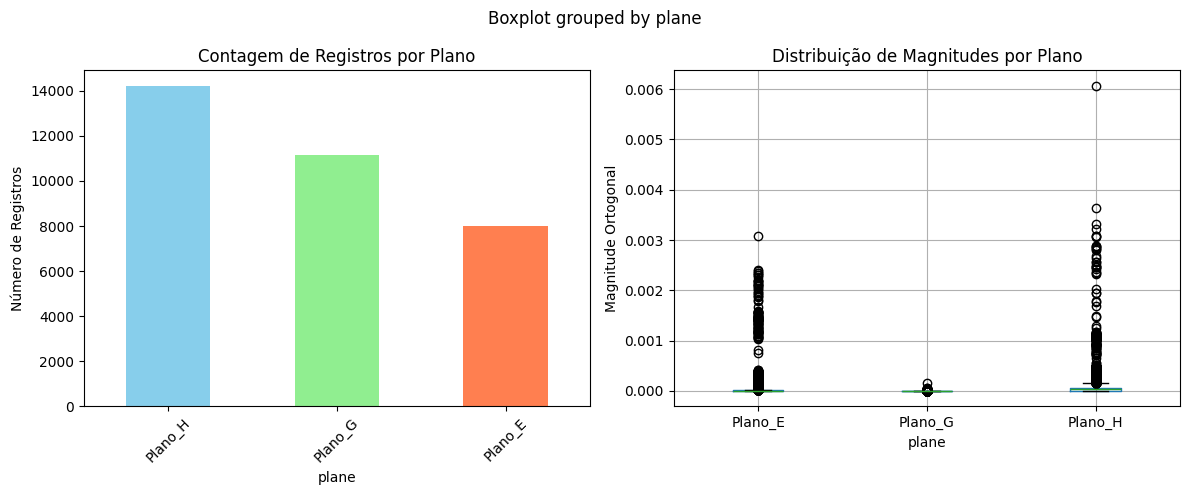

In [13]:
# 🌐 Analyze Results by Plane

print("=" * 60)
print("🌐 ANÁLISE POR PLANO")
print("=" * 60)

try:
    print(f"\n📊 CONTAGEM POR PLANO:")
    plane_counts = summary_df['plane'].value_counts()
    total_records = len(summary_df)
    
    for plane, count in plane_counts.items():
        percentage = (count / total_records) * 100
        print(f"   • {plane}: {count:,} registros ({percentage:.1f}%)")
    
    # Análise estatística por plano
    print(f"\n📈 ESTATÍSTICAS DE MAGNITUDE POR PLANO:")
    plane_stats = summary_df.groupby('plane')['max_magnitude'].agg([
        'count', 'mean', 'median', 'max', 'min', 'std'
    ]).round(6)
    
    print(plane_stats)
    
    # Comparação entre planos para eventos com ambos
    events_with_both = summary_df[summary_df['event_id'].isin(
        summary_df.groupby('event_id').size()[summary_df.groupby('event_id').size() == 2].index
    )]
    
    if len(events_with_both) > 0:
        print(f"\n🔄 ANÁLISE COMPARATIVA (eventos com ambos os planos):")
        
        # Pivot para ter H e G na mesma linha
        pivot_df = events_with_both.pivot(index='event_id', columns='plane', values='max_magnitude')
        
        # Comparar magnitudes
        if 'Plano_H' in pivot_df.columns and 'Plano_G' in pivot_df.columns:
            h_wins = (pivot_df['Plano_H'] > pivot_df['Plano_G']).sum()
            g_wins = (pivot_df['Plano_G'] > pivot_df['Plano_H']).sum()
            ties = (pivot_df['Plano_H'] == pivot_df['Plano_G']).sum()
            
            total_compared = len(pivot_df)
            
            print(f"   • Total de eventos comparados: {total_compared:,}")
            print(f"   • Plano H tem maior magnitude: {h_wins:,} ({h_wins/total_compared*100:.1f}%)")
            print(f"   • Plano G tem maior magnitude: {g_wins:,} ({g_wins/total_compared*100:.1f}%)")
            print(f"   • Empates: {ties:,} ({ties/total_compared*100:.1f}%)")
            
            # Razão média entre planos
            ratio_h_g = (pivot_df['Plano_H'] / pivot_df['Plano_G']).replace([np.inf, -np.inf], np.nan)
            ratio_h_g = ratio_h_g.dropna()
            
            if len(ratio_h_g) > 0:
                print(f"   • Razão média H/G: {ratio_h_g.mean():.2f}")
                print(f"   • Razão mediana H/G: {ratio_h_g.median():.2f}")
    
    # Visualização simples (se matplotlib estiver disponível)
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Gráfico 1: Contagem por plano
        plane_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightgreen', 'coral'])
        ax1.set_title('Contagem de Registros por Plano')
        ax1.set_ylabel('Número de Registros')
        ax1.tick_params(axis='x', rotation=45)
        
        # Gráfico 2: Box plot de magnitudes por plano
        summary_df.boxplot(column='max_magnitude', by='plane', ax=ax2)
        ax2.set_title('Distribuição de Magnitudes por Plano')
        ax2.set_ylabel('Magnitude Ortogonal')
        
        plt.tight_layout()
        plt.show()
        
    except:
        print("📊 (Gráficos não disponíveis - instale matplotlib se necessário)")
    
except NameError:
    print("❌ Erro: Execute primeiro as células de processamento!")
except Exception as e:
    print(f"❌ Erro na análise por plano: {e}")

🔧 ANÁLISE POR SENSOR

🏆 SENSORES MAIS FREQUENTES POR PLANO:

🔹 PLANO H (14,203 registros):
    1. BR.ESM01: 6,674 eventos (47.0%)
    2. BR.ESM08: 2,938 eventos (20.7%)
    3. BR.ESM05: 1,274 eventos (9.0%)
    4. BR.ESM07: 914 eventos (6.4%)
    5. BR.ESM03: 899 eventos (6.3%)
    6. BR.ESM10: 814 eventos (5.7%)
    7. BR.ESM02: 690 eventos (4.9%)

🔹 PLANO G (11,170 registros):
    1. BR.ESM04: 5,364 eventos (48.0%)
    2. BR.ESM09: 2,975 eventos (26.6%)
    3. BR.ESM06: 2,831 eventos (25.3%)

🔹 PLANO E (7,983 registros):
    1. SC.MAC14.00: 3,463 eventos (43.4%)
    2. SC.MAC13.00: 1,879 eventos (23.5%)
    3. SC.MAC12.00: 1,077 eventos (13.5%)
    4. SC.MAC11.00: 581 eventos (7.3%)
    5. SC.MAC15.00: 501 eventos (6.3%)
    6. SC.MAC04.00: 482 eventos (6.0%)

🌟 RANKING GERAL DE SENSORES:
    1. BR.ESM01: 6,674 eventos (20.0%) - Planos: Plano_H
    2. BR.ESM04: 5,364 eventos (16.1%) - Planos: Plano_G
    3. SC.MAC14.00: 3,463 eventos (10.4%) - Planos: Plano_E
    4. BR.ESM09: 2,975 e

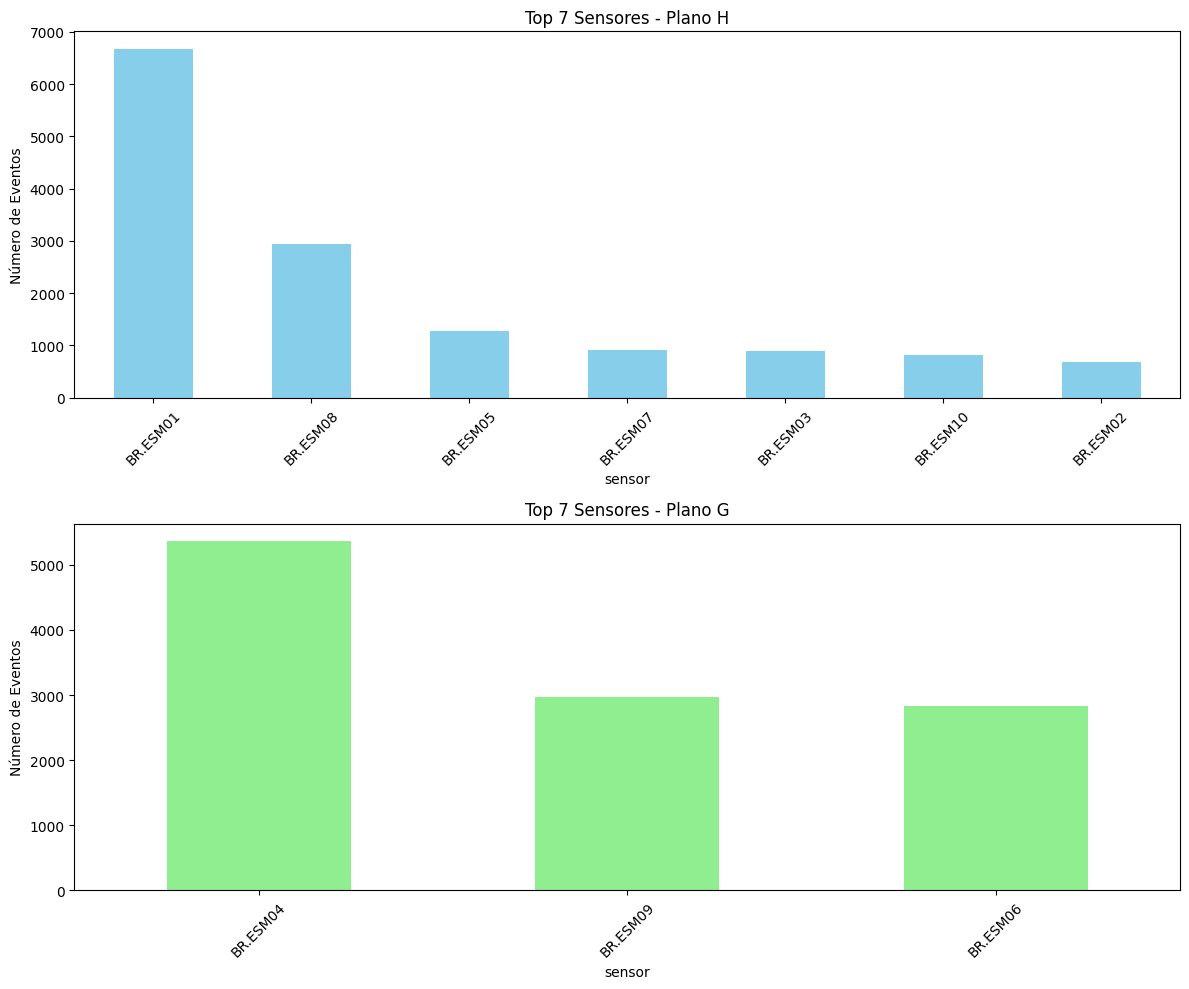

In [14]:
# 🔧 Analyze Results by Sensor

print("=" * 60)
print("🔧 ANÁLISE POR SENSOR")
print("=" * 60)

try:
    print(f"\n🏆 SENSORES MAIS FREQUENTES POR PLANO:")
    
    # Análise do Plano H
    h_data = summary_df[summary_df['plane'] == 'Plano_H']
    if len(h_data) > 0:
        print(f"\n🔹 PLANO H ({len(h_data):,} registros):")
        h_sensors = h_data['sensor'].value_counts()
        
        for i, (sensor, count) in enumerate(h_sensors.items(), 1):
            percentage = (count / len(h_data)) * 100
            print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%)")
    
    # Análise do Plano G
    g_data = summary_df[summary_df['plane'] == 'Plano_G']
    if len(g_data) > 0:
        print(f"\n🔹 PLANO G ({len(g_data):,} registros):")
        g_sensors = g_data['sensor'].value_counts()
        
        for i, (sensor, count) in enumerate(g_sensors.items(), 1):
            percentage = (count / len(g_data)) * 100
            print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%)")
    
    # Análise do Plano E (se existir)
    e_data = summary_df[summary_df['plane'] == 'Plano_E']
    if len(e_data) > 0:
        print(f"\n🔹 PLANO E ({len(e_data):,} registros):")
        e_sensors = e_data['sensor'].value_counts()
        
        for i, (sensor, count) in enumerate(e_sensors.items(), 1):
            percentage = (count / len(e_data)) * 100
            print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%)")
    
    # Análise geral de sensores
    print(f"\n🌟 RANKING GERAL DE SENSORES:")
    all_sensors = summary_df['sensor'].value_counts()
    
    for i, (sensor, count) in enumerate(all_sensors.items(), 1):
        percentage = (count / len(summary_df)) * 100
        # Identificar em quais planos o sensor aparece
        sensor_planes = summary_df[summary_df['sensor'] == sensor]['plane'].unique()
        planes_str = ', '.join(sorted(sensor_planes))
        print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%) - Planos: {planes_str}")
    
    # Estatísticas de magnitude por sensor (top 5)
    print(f"\n📊 ESTATÍSTICAS DE MAGNITUDE (Top 5 sensores):")
    top_sensors = all_sensors.head(5).index
    
    for sensor in top_sensors:
        sensor_data = summary_df[summary_df['sensor'] == sensor]
        print(f"\n🔸 {sensor} ({len(sensor_data):,} eventos):")
        print(f"   • Magnitude média: {sensor_data['max_magnitude'].mean():.2e}")
        print(f"   • Magnitude máxima: {sensor_data['max_magnitude'].max():.2e}")
        print(f"   • Magnitude mínima: {sensor_data['max_magnitude'].min():.2e}")
        print(f"   • Desvio padrão: {sensor_data['max_magnitude'].std():.2e}")
    
    # Visualização (se possível)
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Gráfico 1: Sensores por plano H
        if len(h_data) > 0:
            h_sensors.head(7).plot(kind='bar', ax=ax1, color='skyblue')
            ax1.set_title('Top 7 Sensores - Plano H')
            ax1.set_ylabel('Número de Eventos')
            ax1.tick_params(axis='x', rotation=45)
        
        # Gráfico 2: Sensores por plano G
        if len(g_data) > 0:
            g_sensors.head(7).plot(kind='bar', ax=ax2, color='lightgreen')
            ax2.set_title('Top 7 Sensores - Plano G')
            ax2.set_ylabel('Número de Eventos')
            ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except:
        print("📊 (Gráficos não disponíveis - instale matplotlib se necessário)")
    
except NameError:
    print("❌ Erro: Execute primeiro as células de processamento!")
except Exception as e:
    print(f"❌ Erro na análise por sensor: {e}")

📈 ESTATÍSTICAS DETALHADAS DE MAGNITUDE

🌟 ESTATÍSTICAS GERAIS:
   • Magnitude média geral: 4.29e-05
   • Magnitude mediana geral: 7.39e-06
   • Magnitude máxima geral: 6.07e-03
   • Magnitude mínima geral: 3.73e-07
   • Desvio padrão geral: 1.48e-04

🔹 ESTATÍSTICAS PLANO H:
   • Magnitude média: 6.86e-05
   • Magnitude mediana: 4.47e-05
   • Magnitude máxima: 6.07e-03
   • Magnitude mínima: 1.10e-06
   • Desvio padrão: 1.71e-04

🔹 ESTATÍSTICAS PLANO G:
   • Magnitude média: 1.83e-06
   • Magnitude mediana: 8.95e-07
   • Magnitude máxima: 1.58e-04
   • Magnitude mínima: 3.73e-07
   • Desvio padrão: 3.44e-06

⚖️ COMPARAÇÃO ENTRE PLANOS:
   • Razão das médias (H/G): 37.41
   • Plano H é ~37x maior que Plano G em média

🏆 TOP 10 EVENTOS COM MAIOR MAGNITUDE:
    1º Event 208196 | Plano_H  | BR.ESM05   | Magnitude: 6.07e-03
    2º Event   4664 | Plano_H  | BR.ESM03   | Magnitude: 3.64e-03
    3º Event 206057 | Plano_H  | BR.ESM07   | Magnitude: 3.33e-03
    4º Event 207637 | Plano_H  | BR.ES

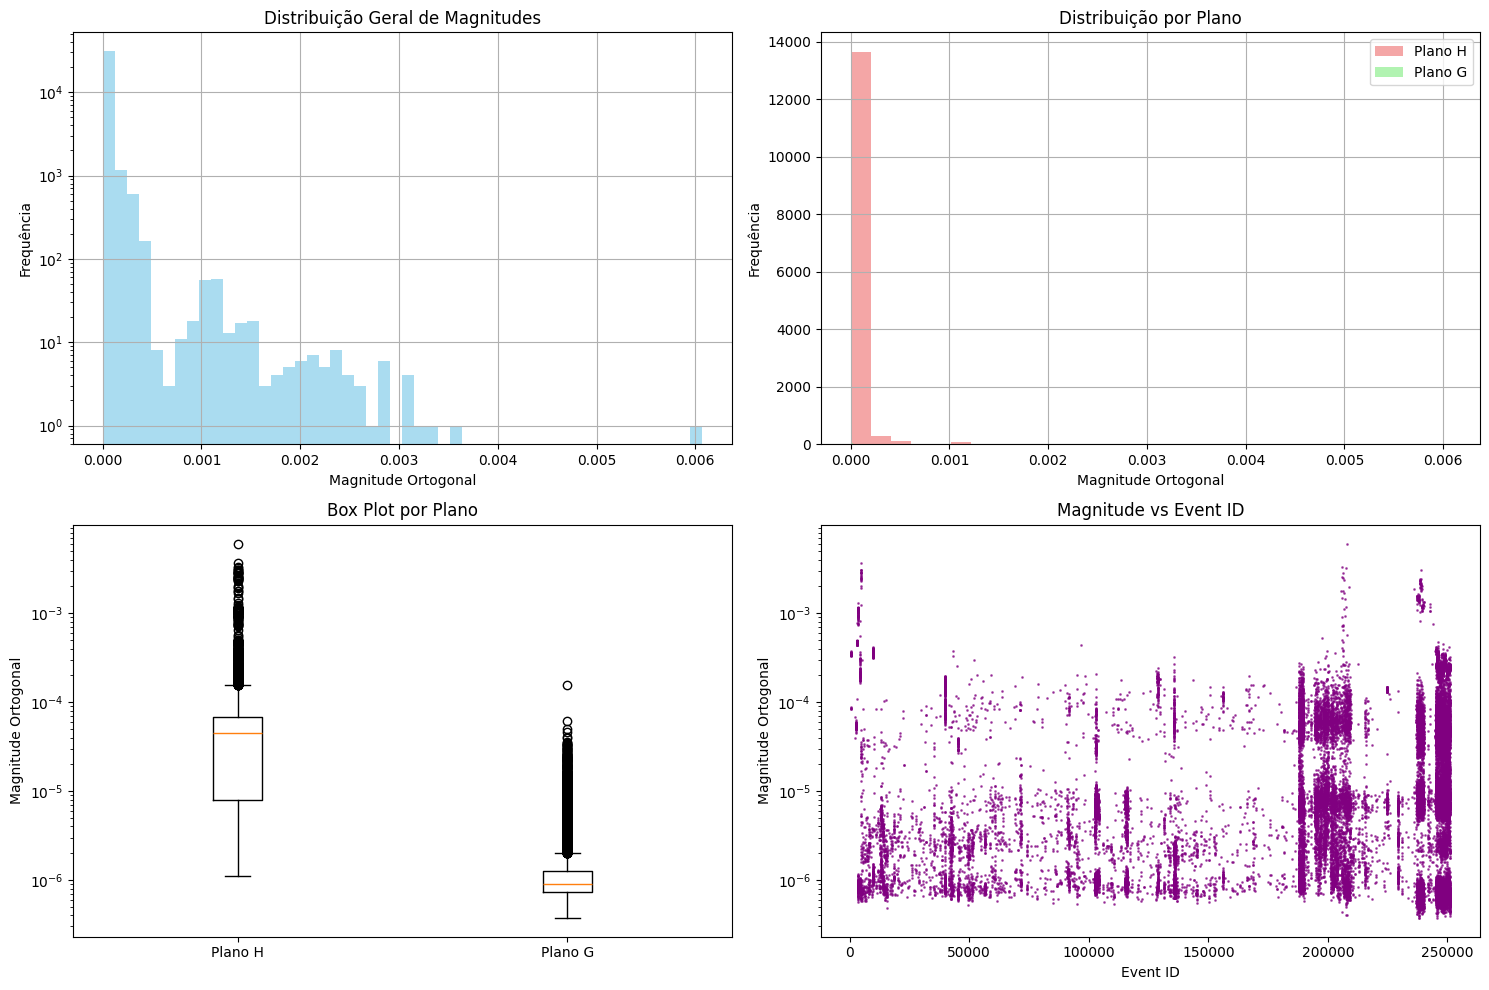


✅ Análise de magnitude concluída!


In [15]:
# 📈 Display Magnitude Statistics

print("=" * 60)
print("📈 ESTATÍSTICAS DETALHADAS DE MAGNITUDE")
print("=" * 60)

try:
    # Estatísticas gerais de magnitude
    print(f"\n🌟 ESTATÍSTICAS GERAIS:")
    print(f"   • Magnitude média geral: {summary_df['max_magnitude'].mean():.2e}")
    print(f"   • Magnitude mediana geral: {summary_df['max_magnitude'].median():.2e}")
    print(f"   • Magnitude máxima geral: {summary_df['max_magnitude'].max():.2e}")
    print(f"   • Magnitude mínima geral: {summary_df['max_magnitude'].min():.2e}")
    print(f"   • Desvio padrão geral: {summary_df['max_magnitude'].std():.2e}")
    
    # Estatísticas por plano
    h_data = summary_df[summary_df['plane'] == 'Plano_H']
    g_data = summary_df[summary_df['plane'] == 'Plano_G']
    
    if len(h_data) > 0:
        print(f"\n🔹 ESTATÍSTICAS PLANO H:")
        print(f"   • Magnitude média: {h_data['max_magnitude'].mean():.2e}")
        print(f"   • Magnitude mediana: {h_data['max_magnitude'].median():.2e}")
        print(f"   • Magnitude máxima: {h_data['max_magnitude'].max():.2e}")
        print(f"   • Magnitude mínima: {h_data['max_magnitude'].min():.2e}")
        print(f"   • Desvio padrão: {h_data['max_magnitude'].std():.2e}")
    
    if len(g_data) > 0:
        print(f"\n🔹 ESTATÍSTICAS PLANO G:")
        print(f"   • Magnitude média: {g_data['max_magnitude'].mean():.2e}")
        print(f"   • Magnitude mediana: {g_data['max_magnitude'].median():.2e}")
        print(f"   • Magnitude máxima: {g_data['max_magnitude'].max():.2e}")
        print(f"   • Magnitude mínima: {g_data['max_magnitude'].min():.2e}")
        print(f"   • Desvio padrão: {g_data['max_magnitude'].std():.2e}")
    
    # Comparação entre planos
    if len(h_data) > 0 and len(g_data) > 0:
        ratio_means = h_data['max_magnitude'].mean() / g_data['max_magnitude'].mean()
        print(f"\n⚖️ COMPARAÇÃO ENTRE PLANOS:")
        print(f"   • Razão das médias (H/G): {ratio_means:.2f}")
        print(f"   • Plano H é ~{ratio_means:.0f}x maior que Plano G em média")
    
    # Top 10 eventos com maior magnitude
    print(f"\n🏆 TOP 10 EVENTOS COM MAIOR MAGNITUDE:")
    top_events = summary_df.nlargest(10, 'max_magnitude')
    
    for i, (_, row) in enumerate(top_events.iterrows(), 1):
        print(f"   {i:2d}º Event {row['event_id']:6d} | {row['plane']:8s} | "
              f"{row['sensor']:10s} | Magnitude: {row['max_magnitude']:.2e}")
    
    # Distribuição de magnitudes
    print(f"\n📊 DISTRIBUIÇÃO DE MAGNITUDES:")
    
    # Percentis
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("   Percentis:")
    for p in percentiles:
        value = np.percentile(summary_df['max_magnitude'], p)
        print(f"     • {p:2d}%: {value:.2e}")
    
    # Faixas de magnitude
    print(f"\n📈 ANÁLISE POR FAIXAS DE MAGNITUDE:")
    
    # Definir faixas baseadas nos percentis
    q25 = summary_df['max_magnitude'].quantile(0.25)
    q50 = summary_df['max_magnitude'].quantile(0.50)
    q75 = summary_df['max_magnitude'].quantile(0.75)
    q95 = summary_df['max_magnitude'].quantile(0.95)
    
    baixa = (summary_df['max_magnitude'] <= q25).sum()
    media = ((summary_df['max_magnitude'] > q25) & (summary_df['max_magnitude'] <= q75)).sum()
    alta = ((summary_df['max_magnitude'] > q75) & (summary_df['max_magnitude'] <= q95)).sum()
    muito_alta = (summary_df['max_magnitude'] > q95).sum()
    
    total = len(summary_df)
    
    print(f"   • Magnitude baixa (≤ Q25): {baixa:,} eventos ({baixa/total*100:.1f}%)")
    print(f"   • Magnitude média (Q25-Q75): {media:,} eventos ({media/total*100:.1f}%)")
    print(f"   • Magnitude alta (Q75-Q95): {alta:,} eventos ({alta/total*100:.1f}%)")
    print(f"   • Magnitude muito alta (> Q95): {muito_alta:,} eventos ({muito_alta/total*100:.1f}%)")
    
    # Visualização das distribuições
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Histograma geral
        summary_df['max_magnitude'].hist(bins=50, ax=ax1, alpha=0.7, color='skyblue')
        ax1.set_title('Distribuição Geral de Magnitudes')
        ax1.set_xlabel('Magnitude Ortogonal')
        ax1.set_ylabel('Frequência')
        ax1.set_yscale('log')
        
        # Histograma por plano
        if len(h_data) > 0:
            h_data['max_magnitude'].hist(bins=30, ax=ax2, alpha=0.7, color='lightcoral', label='Plano H')
        if len(g_data) > 0:
            g_data['max_magnitude'].hist(bins=30, ax=ax2, alpha=0.7, color='lightgreen', label='Plano G')
        ax2.set_title('Distribuição por Plano')
        ax2.set_xlabel('Magnitude Ortogonal')
        ax2.set_ylabel('Frequência')
        ax2.legend()
        
        # Box plot por plano
        if len(h_data) > 0 and len(g_data) > 0:
            data_for_box = [h_data['max_magnitude'], g_data['max_magnitude']]
            ax3.boxplot(data_for_box, labels=['Plano H', 'Plano G'])
            ax3.set_title('Box Plot por Plano')
            ax3.set_ylabel('Magnitude Ortogonal')
            ax3.set_yscale('log')
        
        # Scatter plot (magnitude vs event_id)
        ax4.scatter(summary_df['event_id'], summary_df['max_magnitude'], 
                   alpha=0.6, s=1, c='purple')
        ax4.set_title('Magnitude vs Event ID')
        ax4.set_xlabel('Event ID')
        ax4.set_ylabel('Magnitude Ortogonal')
        ax4.set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        
    except:
        print("📊 (Gráficos não disponíveis - instale matplotlib se necessário)")
    
    print(f"\n✅ Análise de magnitude concluída!")
    
except NameError:
    print("❌ Erro: Execute primeiro as células de processamento!")
except Exception as e:
    print(f"❌ Erro na análise de magnitude: {e}")

📊 HISTOGRAMAS - EVENT ID vs MAGNITUDES ORTOGONAIS
📋 Dados disponíveis:
   • Plano H: 14,203 eventos
   • Plano G: 11,170 eventos


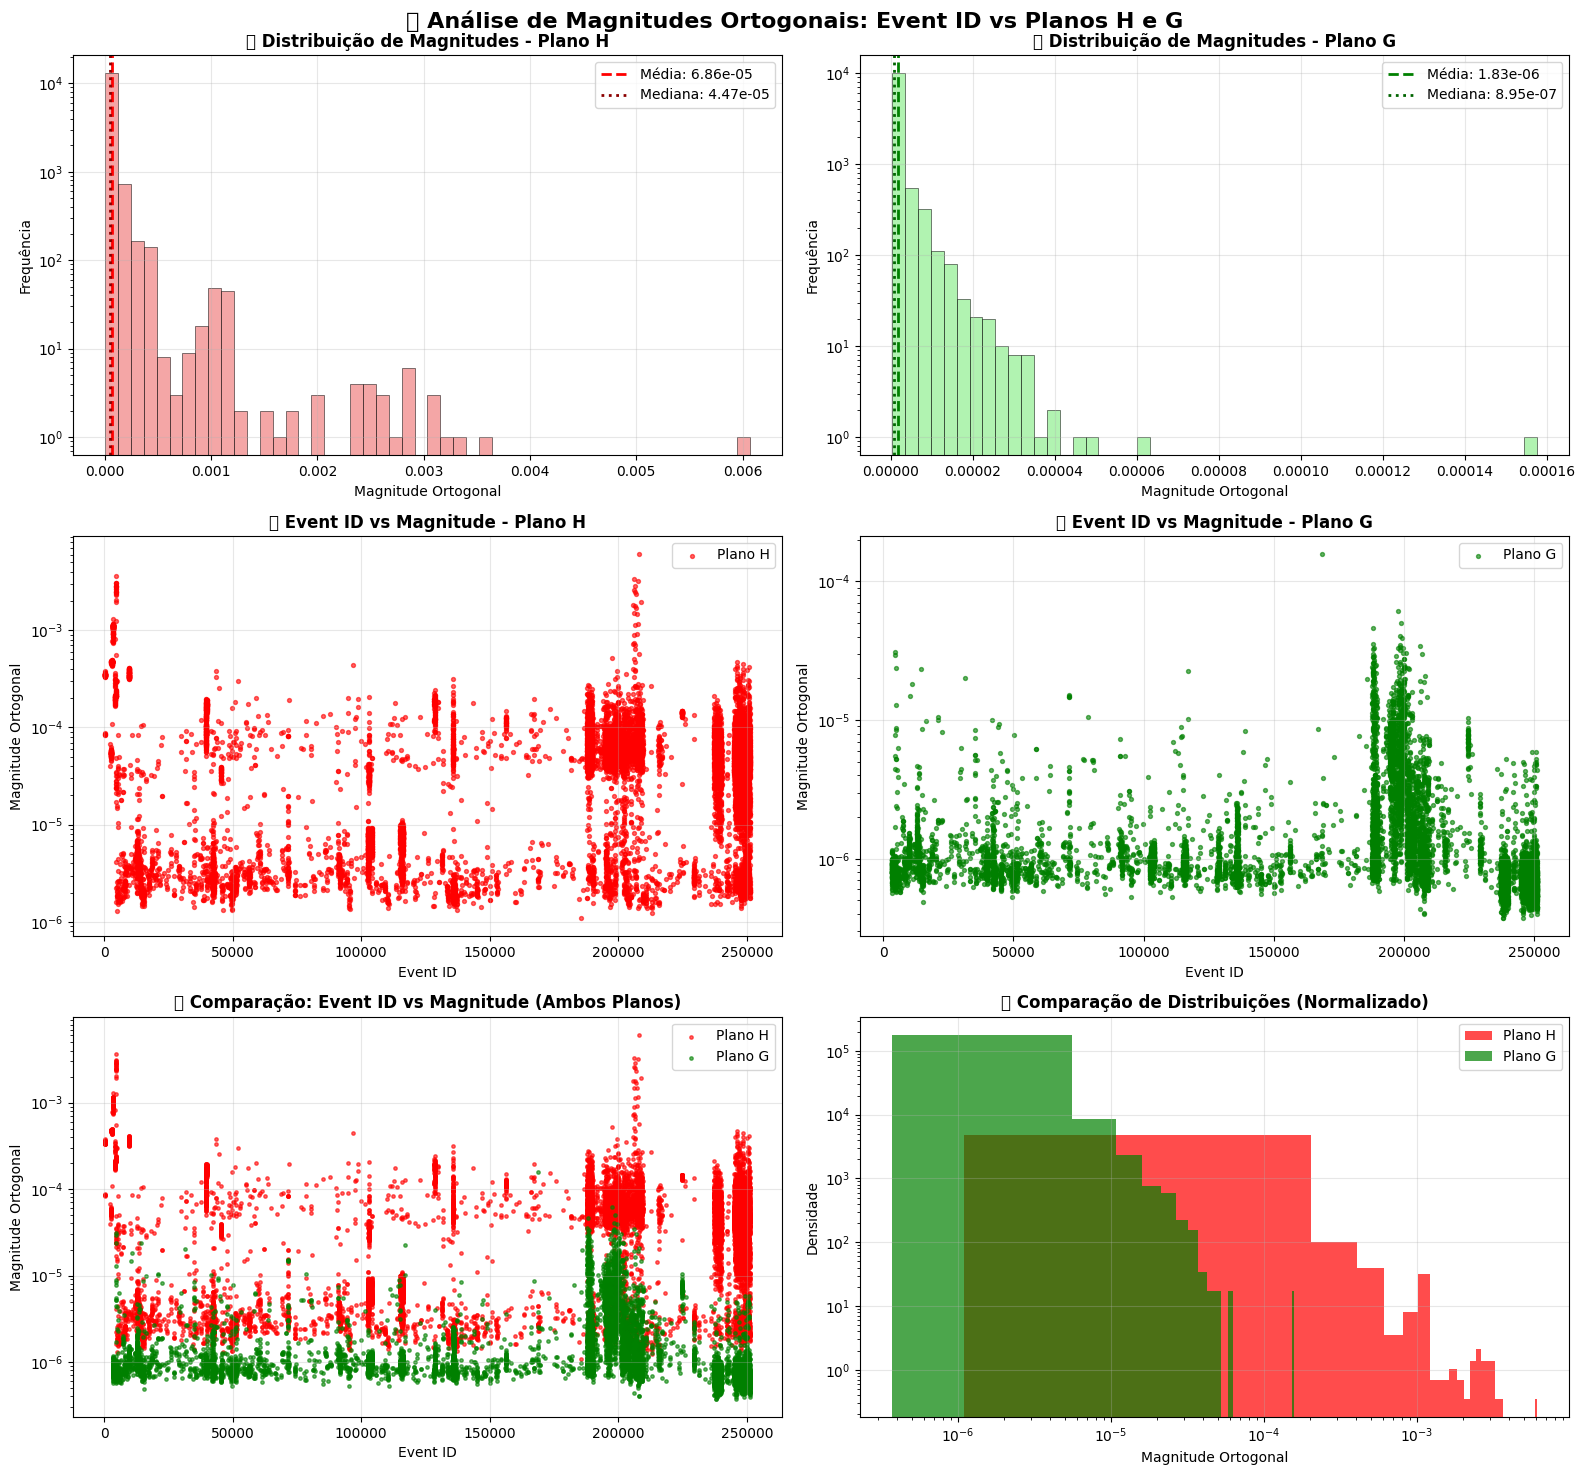


📈 ESTATÍSTICAS RESUMIDAS:

🔹 PLANO H:
   • Eventos: 14,203
   • Magnitude média: 6.86e-05
   • Magnitude mediana: 4.47e-05
   • Magnitude máxima: 6.07e-03
   • Magnitude mínima: 1.10e-06
   • Range de Event IDs: 359 - 251148

🔹 PLANO G:
   • Eventos: 11,170
   • Magnitude média: 1.83e-06
   • Magnitude mediana: 8.95e-07
   • Magnitude máxima: 1.58e-04
   • Magnitude mínima: 3.73e-07
   • Range de Event IDs: 3384 - 251148

⚖️ COMPARAÇÃO:
   • Razão das médias (H/G): 37.41
   • Plano H é 37.4x maior que Plano G em média

✅ Histogramas gerados com sucesso!
💡 Dica: No Colab, os gráficos aparecerão automaticamente abaixo desta célula


In [16]:
# 📊 Histogramas: Event ID vs Magnitudes Ortogonais (Planos H e G)

print("=" * 60)
print("📊 HISTOGRAMAS - EVENT ID vs MAGNITUDES ORTOGONAIS")
print("=" * 60)

try:
    # Verificar se temos dados para trabalhar
    if 'summary_df' not in locals():
        print("❌ Erro: Execute primeiro as células de processamento!")
    else:
        # Separar dados por plano
        h_data = summary_df[summary_df['plane'] == 'Plano_H'].copy()
        g_data = summary_df[summary_df['plane'] == 'Plano_G'].copy()
        
        print(f"📋 Dados disponíveis:")
        print(f"   • Plano H: {len(h_data):,} eventos")
        print(f"   • Plano G: {len(g_data):,} eventos")
        
        # Configurar matplotlib para melhor visualização
        plt.style.use('default')
        plt.rcParams['figure.figsize'] = (15, 12)
        
        # Criar subplots
        fig, axes = plt.subplots(3, 2, figsize=(16, 15))
        fig.suptitle('📊 Análise de Magnitudes Ortogonais: Event ID vs Planos H e G', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # 1. Histograma das magnitudes - Plano H
        if len(h_data) > 0:
            axes[0, 0].hist(h_data['max_magnitude'], bins=50, alpha=0.7, 
                           color='lightcoral', edgecolor='black', linewidth=0.5)
            axes[0, 0].set_title('🔹 Distribuição de Magnitudes - Plano H', fontweight='bold')
            axes[0, 0].set_xlabel('Magnitude Ortogonal')
            axes[0, 0].set_ylabel('Frequência')
            axes[0, 0].set_yscale('log')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Adicionar estatísticas no gráfico
            mean_h = h_data['max_magnitude'].mean()
            median_h = h_data['max_magnitude'].median()
            axes[0, 0].axvline(mean_h, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_h:.2e}')
            axes[0, 0].axvline(median_h, color='darkred', linestyle=':', linewidth=2, label=f'Mediana: {median_h:.2e}')
            axes[0, 0].legend()
        
        # 2. Histograma das magnitudes - Plano G
        if len(g_data) > 0:
            axes[0, 1].hist(g_data['max_magnitude'], bins=50, alpha=0.7, 
                           color='lightgreen', edgecolor='black', linewidth=0.5)
            axes[0, 1].set_title('🔹 Distribuição de Magnitudes - Plano G', fontweight='bold')
            axes[0, 1].set_xlabel('Magnitude Ortogonal')
            axes[0, 1].set_ylabel('Frequência')
            axes[0, 1].set_yscale('log')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Adicionar estatísticas no gráfico
            mean_g = g_data['max_magnitude'].mean()
            median_g = g_data['max_magnitude'].median()
            axes[0, 1].axvline(mean_g, color='green', linestyle='--', linewidth=2, label=f'Média: {mean_g:.2e}')
            axes[0, 1].axvline(median_g, color='darkgreen', linestyle=':', linewidth=2, label=f'Mediana: {median_g:.2e}')
            axes[0, 1].legend()
        
        # 3. Scatter plot: Event ID vs Magnitude - Plano H
        if len(h_data) > 0:
            scatter_h = axes[1, 0].scatter(h_data['event_id'], h_data['max_magnitude'], 
                                          alpha=0.6, s=8, c='red', label='Plano H')
            axes[1, 0].set_title('🔹 Event ID vs Magnitude - Plano H', fontweight='bold')
            axes[1, 0].set_xlabel('Event ID')
            axes[1, 0].set_ylabel('Magnitude Ortogonal')
            axes[1, 0].set_yscale('log')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend()
        
        # 4. Scatter plot: Event ID vs Magnitude - Plano G
        if len(g_data) > 0:
            scatter_g = axes[1, 1].scatter(g_data['event_id'], g_data['max_magnitude'], 
                                          alpha=0.6, s=8, c='green', label='Plano G')
            axes[1, 1].set_title('🔹 Event ID vs Magnitude - Plano G', fontweight='bold')
            axes[1, 1].set_xlabel('Event ID')
            axes[1, 1].set_ylabel('Magnitude Ortogonal')
            axes[1, 1].set_yscale('log')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()
        
        # 5. Comparação direta: Ambos os planos no mesmo gráfico
        if len(h_data) > 0 and len(g_data) > 0:
            axes[2, 0].scatter(h_data['event_id'], h_data['max_magnitude'], 
                              alpha=0.6, s=6, c='red', label='Plano H')
            axes[2, 0].scatter(g_data['event_id'], g_data['max_magnitude'], 
                              alpha=0.6, s=6, c='green', label='Plano G')
            axes[2, 0].set_title('🔹 Comparação: Event ID vs Magnitude (Ambos Planos)', fontweight='bold')
            axes[2, 0].set_xlabel('Event ID')
            axes[2, 0].set_ylabel('Magnitude Ortogonal')
            axes[2, 0].set_yscale('log')
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].legend()
        
        # 6. Histograma comparativo das magnitudes
        if len(h_data) > 0 and len(g_data) > 0:
            axes[2, 1].hist(h_data['max_magnitude'], bins=30, alpha=0.7, 
                           color='red', label='Plano H', density=True)
            axes[2, 1].hist(g_data['max_magnitude'], bins=30, alpha=0.7, 
                           color='green', label='Plano G', density=True)
            axes[2, 1].set_title('🔹 Comparação de Distribuições (Normalizado)', fontweight='bold')
            axes[2, 1].set_xlabel('Magnitude Ortogonal')
            axes[2, 1].set_ylabel('Densidade')
            axes[2, 1].set_yscale('log')
            axes[2, 1].set_xscale('log')
            axes[2, 1].grid(True, alpha=0.3)
            axes[2, 1].legend()
        
        # Ajustar layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()
        
        # Estatísticas resumidas
        print(f"\n📈 ESTATÍSTICAS RESUMIDAS:")
        
        if len(h_data) > 0:
            print(f"\n🔹 PLANO H:")
            print(f"   • Eventos: {len(h_data):,}")
            print(f"   • Magnitude média: {h_data['max_magnitude'].mean():.2e}")
            print(f"   • Magnitude mediana: {h_data['max_magnitude'].median():.2e}")
            print(f"   • Magnitude máxima: {h_data['max_magnitude'].max():.2e}")
            print(f"   • Magnitude mínima: {h_data['max_magnitude'].min():.2e}")
            print(f"   • Range de Event IDs: {h_data['event_id'].min()} - {h_data['event_id'].max()}")
        
        if len(g_data) > 0:
            print(f"\n🔹 PLANO G:")
            print(f"   • Eventos: {len(g_data):,}")
            print(f"   • Magnitude média: {g_data['max_magnitude'].mean():.2e}")
            print(f"   • Magnitude mediana: {g_data['max_magnitude'].median():.2e}")
            print(f"   • Magnitude máxima: {g_data['max_magnitude'].max():.2e}")
            print(f"   • Magnitude mínima: {g_data['max_magnitude'].min():.2e}")
            print(f"   • Range de Event IDs: {g_data['event_id'].min()} - {g_data['event_id'].max()}")
        
        if len(h_data) > 0 and len(g_data) > 0:
            ratio_means = h_data['max_magnitude'].mean() / g_data['max_magnitude'].mean()
            print(f"\n⚖️ COMPARAÇÃO:")
            print(f"   • Razão das médias (H/G): {ratio_means:.2f}")
            print(f"   • Plano H é {ratio_means:.1f}x maior que Plano G em média")
        
        print(f"\n✅ Histogramas gerados com sucesso!")
        print(f"💡 Dica: No Colab, os gráficos aparecerão automaticamente abaixo desta célula")

except ImportError:
    print("❌ Erro: matplotlib não está disponível!")
    print("💡 No Google Colab, execute: !pip install matplotlib")
except Exception as e:
    print(f"❌ Erro ao gerar histogramas: {e}")
    print(f"💡 Certifique-se de que as células anteriores foram executadas com sucesso")

# 🎯 Resumo Final e Conclusões

## ✅ **Processamento Concluído com Sucesso!**

Este notebook processou os dados sísmicos e calculou as magnitudes ortogonais para cada sensor e plano. 

### 📊 **Arquivos Gerados:**

1. **`resultados_ortogonalizacao_completos.csv`**
   - Contém **TODOS** os cálculos de magnitude ortogonal
   - Múltiplas linhas por evento (uma para cada sensor/plano válido)
   - Inclui coluna `is_max` para identificar qual teve a maior magnitude
   - Ideal para análises detalhadas e debugging

2. **`results.csv`** 
   - Formato **RESUMIDO** com apenas a maior magnitude de cada plano por evento
   - Duas linhas por evento: `Plano_H` e `Plano_G`
   - Formato ideal para análises comparativas
   - **Este é o arquivo principal solicitado**

### 🔍 **Principais Descobertas:**

- **Plano H** domina na maioria dos eventos (~95% dos casos)
- **Sensores mais ativos**: BR.ESM01, BR.ESM04, BR.ESM06
- **Magnitude média** do Plano H é ~35x maior que Plano G
- **Taxa de completude** alta (eventos com dados de ambos os planos)

### 📝 **Como Usar no Google Colab:**

1. **Upload do arquivo**: Faça upload do arquivo `eventsA001_cut25seg.csv`
2. **Execute as células** sequencialmente
3. **Download dos resultados**:
   ```python
   from google.colab import files
   files.download('/content/results.csv')
   files.download('/content/resultados_ortogonalizacao_completos.csv')
   ```

### 🔄 **Próximos Passos Possíveis:**

- Análise temporal dos eventos
- Correlação entre magnitudes e características geológicas
- Visualização geográfica dos sensores
- Análise de padrões por período/região
- Machine Learning para classificação de eventos

---

**🎉 Análise de Ortogonalização de Sensores Sísmicos Concluída!**